In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import librosa.display
from glob import glob
import os
from tqdm import tqdm

In [2]:
def splitData(X, t, testFraction=0.2, randomize = False):
    """
    Split the data randomly into training and test sets
    Use numpy functions only
    Inputs:
        X: (np array of len Nsamples) input feature vectors
        t: (np array of len Nsamples) targets; one hot vectors
        testFraction: (float) Nsamples_test = testFraction * Nsamples
    Outputs:
        X_train: training set
        X_test: test set
        t_train: training labels
        t_test: test labels
    """
    if randomize is False:
      tot_samples = np.random.RandomState(seed=42).permutation(len(X))
    else:
      tot_samples = np.random.permutation(len(X))

    X_train = []
    X_test = []
    t_train = []
    t_test = []
    
    test_samples = max(1,int(len(X)*testFraction))
    # print(tot_samples[:test_samples])
    # print(tot_samples[test_samples:])

    for i in range(test_samples):
      X_test.append(X[tot_samples[i]])
      t_test.append(t[tot_samples[i]])

    for i in range(test_samples,len(X)):
      X_train.append(X[tot_samples[i]])
      t_train.append(t[tot_samples[i]])
    
    return np.asarray(X_train), np.asarray(t_train), np.asarray(X_test), np.asarray(t_test)

def calc_spec(x):
    n_fft = 1024
    hop_length = 512
    win_length = 1024
    X = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann'))
    X = librosa.power_to_db(X**2,ref=np.max)
    return X

def audio2spec(x, norm=True, mfcc=True):
    
    '''
    Compute Mel-frequency cepstral coefficients (MFCCs)
    Inputs:
        x: np array of shape (Nsamples,)
    Output:
        X: (np array) spectrogram sequence
    '''
    X=[]
    for sample in x:
      if mfcc is False:
        X.append(calc_spec(sample))
      else:
        X.append(librosa.feature.mfcc(S=calc_spec(sample), n_mfcc=20))  
    if norm is True:
      X = (X-np.mean(X))/np.std(X)
    return np.asarray(X)

In [3]:
# PARAMETER FOR STFT
SAMPLING_RATE=16000
DURATION=10
N_FFT = 1024
WIN_LENGTH = 1024
HOP_LENGTH = 512

In [4]:
# LOADING THE TRAINING SPECTROGRAMS
X = np.load('/content/drive/MyDrive/Sem 5/EE603/project/val_set/Final_Dataset/training_spectrogram.npy')
print(X.shape)
y = np.load('/content/drive/MyDrive/Sem 5/EE603/project/val_set/Final_Dataset/training_labels.npy')
print(y.shape)
# from sklearn.utils import shuffle
# X, y = shuffle(X, y)

(717, 513, 313)
(717,)


In [5]:
# EXTRACTING THE MFCC FEATURES FROM THE SPECTROGRAM
def get_mfcc(X):
  X_new = []
  for i in range(len(X)):
    mel_spectrogram = librosa.feature.melspectrogram(S=X[i], n_fft=N_FFT, hop_length=HOP_LENGTH)
    mfcc = librosa.feature.mfcc(S=mel_spectrogram, sr=16000,n_mfcc=20)
    mean = np.average(mfcc)
    std = np.std(mfcc)
    if(std == 0):
      std = std + 1e-25
    mfcc = (mfcc - mean)/std
    X_new.append(mfcc)
  return np.array(X_new)
X = get_mfcc(X)

In [6]:
# FUNCTIONS TO CONVERT STRING TO ONE-HOT-VECTORS
def one_hot_enc(cl_name):
  if(cl_name == 'music'):
    return np.array([0,1,0])
  elif(cl_name == 'speech'):
    return np.array([1,0,0])
  else:
    return np.array([0,0,1])

def string2ohv(y):
  y_ohv = []
  for i in y:
    y_ohv.append(one_hot_enc(i))
  return np.array(y_ohv)

In [7]:
X_train, y_train, X_test, y_test = splitData(X=X, t=y, testFraction=0.2, randomize=True)
print(X_train.shape)
print(X_test.shape)

(574, 20, 313)
(143, 20, 313)


In [8]:
# RESHAPING THE DATA
def reshape(X, y):
  # Reshape the data to make each entry in the spectrogram a training sample
  X_new = []
  y_new = []
  for i in range(len(X)):
    X_new.append(np.transpose(X[i]))
    # print(X[i].shape[1])
    y_new.append([y[i]]*X[i].shape[1])
    # print(np.shape(y_new))
  X_new = np.array(X_new)
  y_new = np.array(y_new)
  X_new = X_new.reshape((-1, X[0].shape[0]))
  y_new = y_new.reshape((-1, 1))
  print(X_new.shape)
  print(y_new.shape)
  return X_new, y_new
X_train, y_train = reshape(X_train, y_train)
X_test, y_test = reshape(X_test, y_test)
y_test = string2ohv(y_test)
y_train = string2ohv(y_train)
print(y_train.shape)
print(y_test.shape)

(179662, 20)
(179662, 1)
(44759, 20)
(44759, 1)
(179662, 3)
(44759, 3)


In [9]:
# PREPARING THE BAG OF FRAMES TO ESTABLISH TEMPORAL DEPENDENCE
def make_bags(X_prev):
  X_new = []
  X_new.append(X_prev[:7])
  X_new.append(X_prev[:7])
  X_new.append(X_prev[:7])

  for i in tqdm(range(len(X_prev)-6)):
    A = X_prev[i:i+7]
    X_new.append(A)

  X_new.append(X_prev[-7:])
  X_new.append(X_prev[-7:])
  X_new.append(X_prev[-7:])
  
  X_new = np.array(X_new)
  return X_new
X_test_reshaped = make_bags(X_test)
print(X_test_reshaped.shape)
X_train_reshaped = make_bags(X_train)
print(X_train_reshaped.shape)

100%|██████████| 44753/44753 [00:00<00:00, 1093676.44it/s]


(44759, 7, 20)


100%|██████████| 179656/179656 [00:00<00:00, 1190571.70it/s]


(179662, 7, 20)


In [10]:
from scipy.stats import multivariate_normal 
from scipy.stats import mode

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter) 

    def initialize(self, X):
        self.shape = X.shape 
        self.n, self.m = self.shape 
        self.phi = np.full(shape=self.k, fill_value=1/self.k) 
        self.weights = np.full(shape=self.shape, fill_value=1/self.k)
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ] 
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ] 

    def e_step(self, X):
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)

    def m_step(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

    def fit(self, X):
        self.initialize(X)
        for iteration in tqdm(range(self.max_iter)):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (X.shape[0], self.k) ) 
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i],cov=self.sigma[i], allow_singular=True)
            likelihood[:,i] = distribution.pdf(X) 
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [13]:
EPOCHS = 15
X_train = np.reshape(X_train_reshaped, (np.shape(X_train_reshaped)[0],-1))
X_test = np.reshape(X_test_reshaped, (np.shape(X_test_reshaped)[0],-1))

print(np.shape(X_train), np.shape(X_test))

(179662, 140) (44759, 140)


In [14]:
gmm = GMM(k=3, max_iter=EPOCHS)
gmm.fit(X_train[:10**3])

100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


In [25]:
%cd /content/drive/MyDrive/Sem 5/EE603/project

/content/drive/MyDrive/Sem 5/EE603/project


In [26]:
with open('gmm_weights.npy', 'wb') as f:
  np.save(f,gmm.weights)

In [15]:
y_hat = gmm.predict(X_test[:1000])

In [16]:
Y_num = []

for label in tqdm(y_test[:1000]):
  if label[1] == 1:
    Y_num.append(2) #music
  elif label[0] == 1:
    Y_num.append(1) #speech
  else:
    Y_num.append(0) #silence

print(len(Y_num))

100%|██████████| 1000/1000 [00:00<00:00, 696265.60it/s]

1000


In [22]:
import sklearn
print(sklearn.metrics.f1_score(y_hat, Y_num, average='micro'))

0.311


Accuracy: 0.6803699897225077


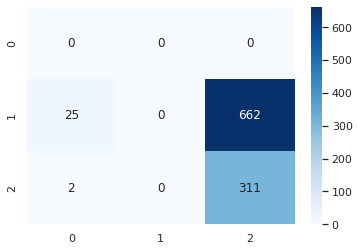

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_num, y_hat)
import seaborn as sns; sns.set()

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

from scipy.optimize import linear_sum_assignment as linear_assignment
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

print("Accuracy:",np.trace(cm2) / np.sum(cm2))

In [21]:
print(cm2)

[[  0   0]
 [  0 662]
 [  0 311]]
